<center>
    <u><font size="36">Binary Classifier</font></u>
    <h2>by Rebecca Hinrichs</h2>
    <h4>SPRING 2023</h4>
</center>

<b>Purpose:</b> The goal of this assignment is to create a binary classification problem using `sklearn.datasets.make_moons` and build a Support Vector Machines (SVM) classification model & investigate the effects of hyper-parameters $C$, $\gamma$, and kernels on the model's performance.

<b>Data:</b> We were instructed to import the publicly-available `sklearn.datasets.make_moons`. The data generates two half-moon shape scatterplot figures consisting of two classes, identified by their colors, and intermixes the points along the boundaries according to the `noise` parameter setting.<br>

<b>Approach:</b> We will build & train a SVM model using `scikit-learn`'s built-in methods. Using cross-validation methods to tune our hyperparameters, we will save and report the accuracies of the best model. 

--- -

> 1. Import the data

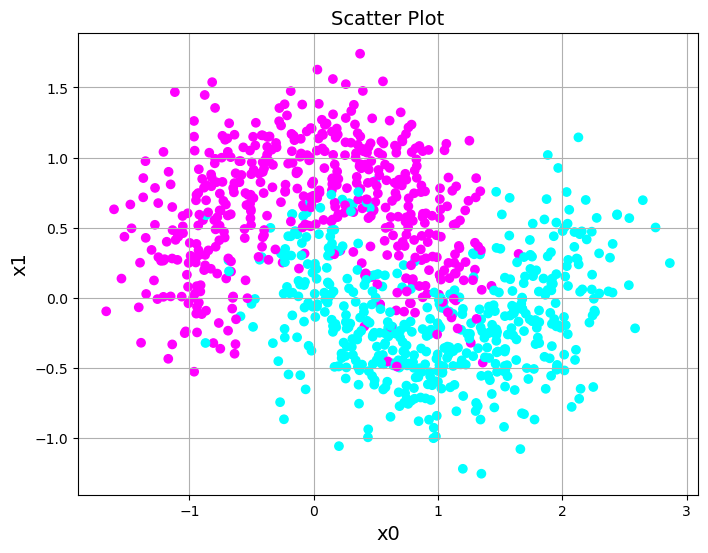

In [1]:
# Import Libraries & Dependencies
import numpy as np

# Import Dataset
from sklearn.datasets import make_moons

# Define the feature and target variables for training, testing
X, y = make_moons(n_samples = 1000,
                  noise = 0.3,
                  random_state = 42)

# Demonstrate the Dataset
import matplotlib.pyplot as plt
colors = ['magenta' if label == 0 else 'aqua' for label in y]
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], color = colors)
plt.xlabel("x0", fontsize = 14)
plt.ylabel("x1", fontsize=14)
plt.title("Scatter Plot", fontsize=14)
plt.grid();

In [2]:
# Target variable analysis
classes = np.unique(y, return_counts=True)
print(f'<Label>\t<Count>\t<Percent>')
for label, size in zip(classes[0], classes[1]):
    print(f'{label:>5}\t{size:>5}\t  {size/len(y):.1%}')

<Label>	<Count>	<Percent>
    0	  500	  50.0%
    1	  500	  50.0%


> 2. Preprocess the `y` data as necessary

In [3]:
# Encode the target variable to ensure no ordinality in the class labels
from sklearn.preprocessing import LabelEncoder
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(y)
print(f'Sample of encoded target variable ::\n'\
      f'{np.round(y[np.random.randint(y.shape[0])], 4)}')

Sample of encoded target variable ::
1


> 3.  Split the data into training and testing sets

In [4]:
# Split the data into training & testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, random_state=42)
# Report the dataset shapes
print(f'\nTraining Shape :: {X_train.shape}')
print(f'Training Labels :: {y_train.shape}')
print(f'\nTesting Shape :: {X_test.shape}')
print(f'Testing Labels :: {y_test.shape}\n')


Training Shape :: (700, 2)
Training Labels :: (700,)

Testing Shape :: (300, 2)
Testing Labels :: (300,)



> 4. Preprocess the `X` data as necessary

In [5]:
# Scale the numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f'Sample of scaled numeric features::\n'\
      f'{np.round(X_train_scaled[np.random.randint(X_train_scaled.shape[0]), :], 4)}\n')

Sample of scaled numeric features::
[1.6679 0.5206]



--- 

<center><h3>`kernel`</h3></center>

--- 

> 5.  Build a Support Vector Classifier using the training data.

In [14]:
# Find the optimal 'kernel' hyperparameter
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
find_kernel = GridSearchCV(estimator = SVC(),
                           param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                         'degree': range(2, 10, 1)},  # degree ranges if 'poly' is used
                           cv = 5, scoring = 'accuracy')
find_kernel.fit(X_train_scaled, y_train)
optimal_kernel = find_kernel.best_params_['kernel']  # we'll ignore 'degree' if 'kernel'!='poly'
optimal_kernel

'rbf'

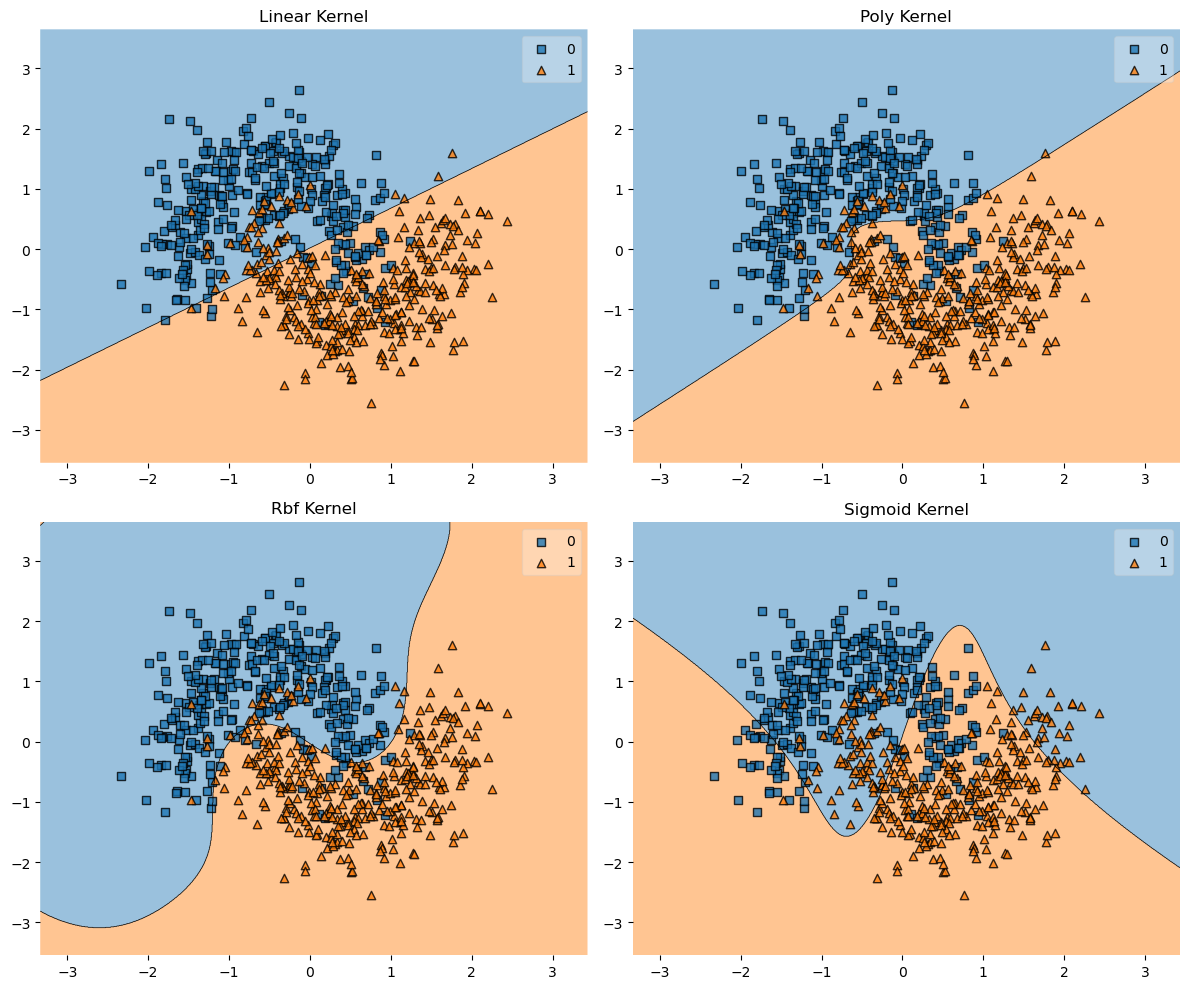

In [7]:
# Find the kernel shape to describe the fit
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Plot each model's decision boundary region analysis
from mlxtend.plotting import plot_decision_regions
fig, axes = plt.subplots(2,2, figsize=(12,10))
for ax, kernel in zip(axes.flatten(), kernels):
    model = SVC(kernel=kernel).fit(X_train_scaled, y_train)
    plot_decision_regions(X_train_scaled, y_train, clf=model, ax=ax)
    ax.set_title(str(kernel).capitalize()+" Kernel")
fig.tight_layout()

It's clear that the Gaussian `rbf` kernel provides the best-fit contour, as already suggested by our `GridSearchCV` inquiry. Now we'll look for the best $C$ value.

--- 

<center><h3>$C$</h3></center>

--- 

> 5.  Build a Support Vector Classifier using the training data.

In [9]:
# Find the optimal 'C' hyperparameter
from sklearn.model_selection import GridSearchCV
find_C = GridSearchCV(estimator = SVC(),  # <<-- already uses 'rbf' kernel
                      param_grid = {'C': np.logspace(-3, 3, 7)},  # Search between 0.001 and 1000 on a log scale
                      cv = 10, scoring = 'accuracy')
find_C.fit(X_train_scaled, y_train)
optimal_C = find_C.best_params_['C']
optimal_C

100.0

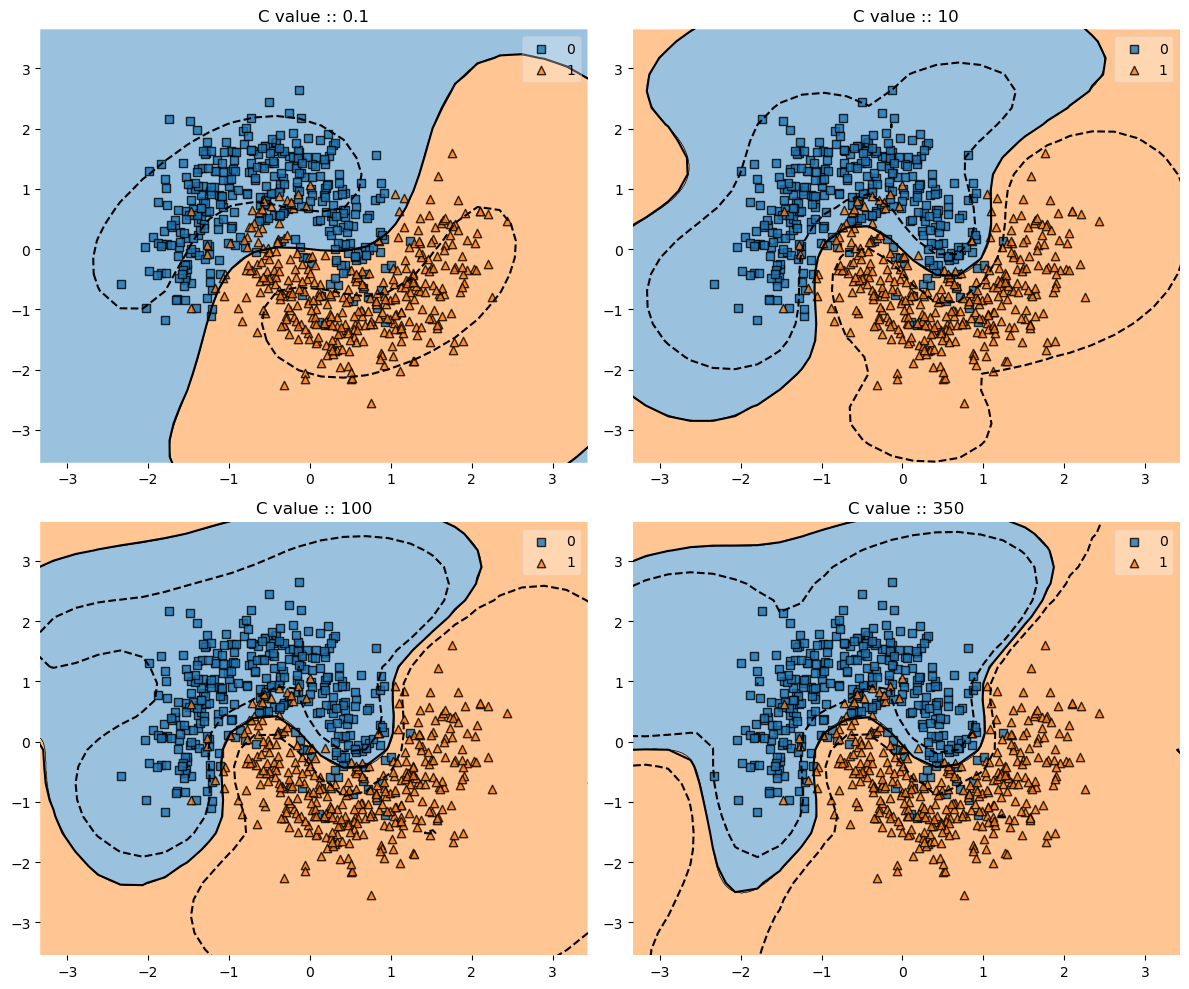

In [10]:
# Find the allowed violation factor 'C' to describe the best fit
from sklearn.svm import SVC
C_vals = [0.1, 10, 100, 350]  # to demonstrate visual differences
violators = list()  # to store for error evaluation

# Plot each model's decision boundary analysis
from mlxtend.plotting import plot_decision_regions
fig, axes = plt.subplots(2,2, figsize=(12,10))
xx = np.linspace(-4, 4, 30)
yy = np.linspace(-4, 4, 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
for ax, c in zip(axes.flatten(), C_vals):
    model = SVC(C=c).fit(X_train_scaled, y_train)
    model.name_ = 'rbf_'+str(c)+'_model'
    violators.append(model)
    plot_decision_regions(X_train_scaled, y_train, clf=model, ax=ax)
    Z = model.decision_function(xy).reshape(XX.shape)
    ax.contour(XX, YY, Z, colors = 'k', levels = [-1, 0, 1], linestyles=["--", "-", "--"])
    ax.set_title("C value :: "+str(c))
fig.tight_layout()

The smallest $0.1$ factor is clearly unfit to hold our data, but it is admittedly difficult to judge the others from our two-dimensional overlook. Rather than spending a lot of computation in analyzing 3D graphs, we can implement one more technique to examine the other 3.

> 6.  Inspect the evaluation measures such as MAE, MSE, or RMSE.

In [12]:
# Calculate Errors from model predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error
def report_errors(modelname, X_data, y_data):
    print(f'Mean Absolute Error (MAE) :: {np.round(mean_absolute_error(y_data, modelname.predict(X_data)), 4)}\n' \
          f'Mean Squared Error (MSE) :: {np.round(mean_squared_error(y_data, modelname.predict(X_data)), 4)}\n' \
          f'Root Mean Squared Error (RMSE) :: {np.round(mean_squared_error(y_data, modelname.predict(X_data), squared=False), 4)}\n')
for C_val, violator in zip(C_vals[1:], violators[1:]):  # ignoring C=0.1
    print(f'\nThe Errors produced by {violator.name_} using `C`={C_val}'\
          f'\n...on the Training Data...')
    report_errors(violator, X_train_scaled, y_train)  # prediction accuracy
    print(f'...and on the Testing Data...')
    report_errors(violator, X_test_scaled, y_test)  # true accuracy
    print(f'- - - - - - - - - - - - - - - - - - - - - - - - - - -')


The Errors produced by rbf_10_model using `C`=10
...on the Training Data...
Mean Absolute Error (MAE) :: 0.0829
Mean Squared Error (MSE) :: 0.0829
Root Mean Squared Error (RMSE) :: 0.2878

...and on the Testing Data...
Mean Absolute Error (MAE) :: 0.09
Mean Squared Error (MSE) :: 0.09
Root Mean Squared Error (RMSE) :: 0.3

- - - - - - - - - - - - - - - - - - - - - - - - - - -

The Errors produced by rbf_100_model using `C`=100
...on the Training Data...
Mean Absolute Error (MAE) :: 0.0771
Mean Squared Error (MSE) :: 0.0771
Root Mean Squared Error (RMSE) :: 0.2777

...and on the Testing Data...
Mean Absolute Error (MAE) :: 0.0833
Mean Squared Error (MSE) :: 0.0833
Root Mean Squared Error (RMSE) :: 0.2887

- - - - - - - - - - - - - - - - - - - - - - - - - - -

The Errors produced by rbf_350_model using `C`=350
...on the Training Data...
Mean Absolute Error (MAE) :: 0.0786
Mean Squared Error (MSE) :: 0.0786
Root Mean Squared Error (RMSE) :: 0.2803

...and on the Testing Data...
Mean Abso

Our results for $C=100$ and $C=350$ are comparable on the testing data, but slightly higher on $C=350$'s training data. Though more testing would be necessary to confirm, for our purposes here, we can deduce that as $C$ increases past $100$, we may risk higher susceptibility toward overfitting. Therefore in agreement with our `optimal_C` we found earlier using `GridSearchCV`, we can deduce that $C=100$ is indeed our best result.

--- 

<center><h3>$\gamma$</h3></center>

--- 

> 5.  Build a Support Vector Classifier using the training data.

In [20]:
# Find the optimal 'gamma' hyperparameter using sklearn formulas
from sklearn.model_selection import GridSearchCV
find_gamma1 = GridSearchCV(estimator = SVC(C=optimal_C),
                          param_grid = {'kernel': ['poly', 'rbf', 'sigmoid'],  # gamma uses all but linear
                                        'degree': range(2, 10, 1),  # degree ranges if 'poly' is used
                                        'gamma': ['scale','auto']},  # Using sklearn's built-in options
                          cv = 5, scoring = 'accuracy')
find_gamma1.fit(X_train_scaled, y_train)
if find_gamma1.best_params_['kernel'] != 'poly':
    find_gamma1.best_params_.pop('degree',None)
find_gamma1.best_params_

{'gamma': 'scale', 'kernel': 'rbf'}

In [24]:
# Find the optimal 'gamma' hyperparameter using numerical range
# from sklearn.model_selection import RandomizedSearchCV  # because GridSearchCV will take way too long!
# find_gamma2 = RandomizedSearchCV(estimator = SVC(C=optimal_C),  # <<<--- this kept crashing my kernel after running for 3 hours each time!
#                                  param_distributions = {'kernel': ['poly', 'rbf', 'sigmoid'],  # gamma uses all but linear
#                                                         'gamma': np.logspace(-3, 3, 7),  # Search between 0.001 and 1000 on a log scale
#                                                         'degree': range(1, 10, 1)},  # degree ranges if 'poly' is used
#                                  n_iter = 100, cv = 5, scoring = 'accuracy')
find_gamma2 = GridSearchCV(estimator = SVC(kernel=optimal_kernel),  # Ditching 'poly' & 'sigmoid' cuz the complexity keeps killing my kernels
                           param_grid = {'C': np.logspace(-3, 3, 7),  # Since C and gamma behave somewhat inversely, we'll introduce this again
                                         'gamma': np.logspace(-3, 3, 7)},  # Search between 0.001 and 1000 on a log scale
                           cv = 5, scoring = 'accuracy')
find_gamma2.fit(X_train_scaled, y_train)
find_gamma2.best_params_

{'C': 0.1, 'gamma': 10.0}

In [25]:
# Find the optimal 'gamma' hyperparameter using previously-found optimal 'C' with defaults
find_gamma3 = GridSearchCV(estimator = SVC(kernel=optimal_kernel,C=optimal_C),
                           param_grid = {'gamma': np.logspace(-3, 3, 7)},  # Search between 0.001 and 1000 on a log scale
                           cv = 5, scoring = 'accuracy')
find_gamma3.fit(X_train_scaled, y_train)
find_gamma3.best_params_

{'gamma': 1.0}

In [56]:
# Determine best 'gamma' hyperparameter combination based on True Prediction scores
optimal_gamma = dict()
score1 = find_gamma1.score(X_test_scaled,y_test)
score2 = find_gamma2.score(X_test_scaled,y_test)
score3 = find_gamma3.score(X_test_scaled,y_test)
if score1 > score2 and score1 > score3:
    optimal_gamma['estimator'] = find_gamma1.best_estimator_
    optimal_gamma['kernel'] = find_gamma1.best_params_['kernel']
    optimal_gamma['C'] = optimal_C
    optimal_gamma['gamma'] = find_gamma1.best_params_['gamma']
    optimal_gamma['score'] = round(score1, 4)
elif score2 > score1 and score2 > score3:
    optimal_gamma['estimator'] = find_gamma2.best_estimator_
    optimal_gamma['kernel'] = optimal_kernel
    optimal_gamma['C'] = find_gamma2.best_params_['C']
    optimal_gamma['gamma'] = find_gamma2.best_params_['gamma']
    optimal_gamma['score'] = round(score2, 4)
elif score3 > score1 and score3 > score2:
    optimal_gamma['estimator'] = find_gamma3.best_estimator_
    optimal_gamma['kernel'] = optimal_kernel
    optimal_gamma['C'] = optimal_C
    optimal_gamma['gamma'] = find_gamma3.best_params_['gamma']
    optimal_gamma['score'] = round(score3, 4)
else:
    print(f'\nWhoa, you did something wrong here....\n')
print(f'\nBest Gamma Combination based on Test Predictions ::\n' \
      f'{optimal_gamma}\n')


Best Gamma Combination based on Test Predictions ::
{'estimator': SVC(C=0.1, gamma=10.0), 'kernel': 'rbf', 'C': 0.1, 'gamma': 10.0, 'score': 0.92}



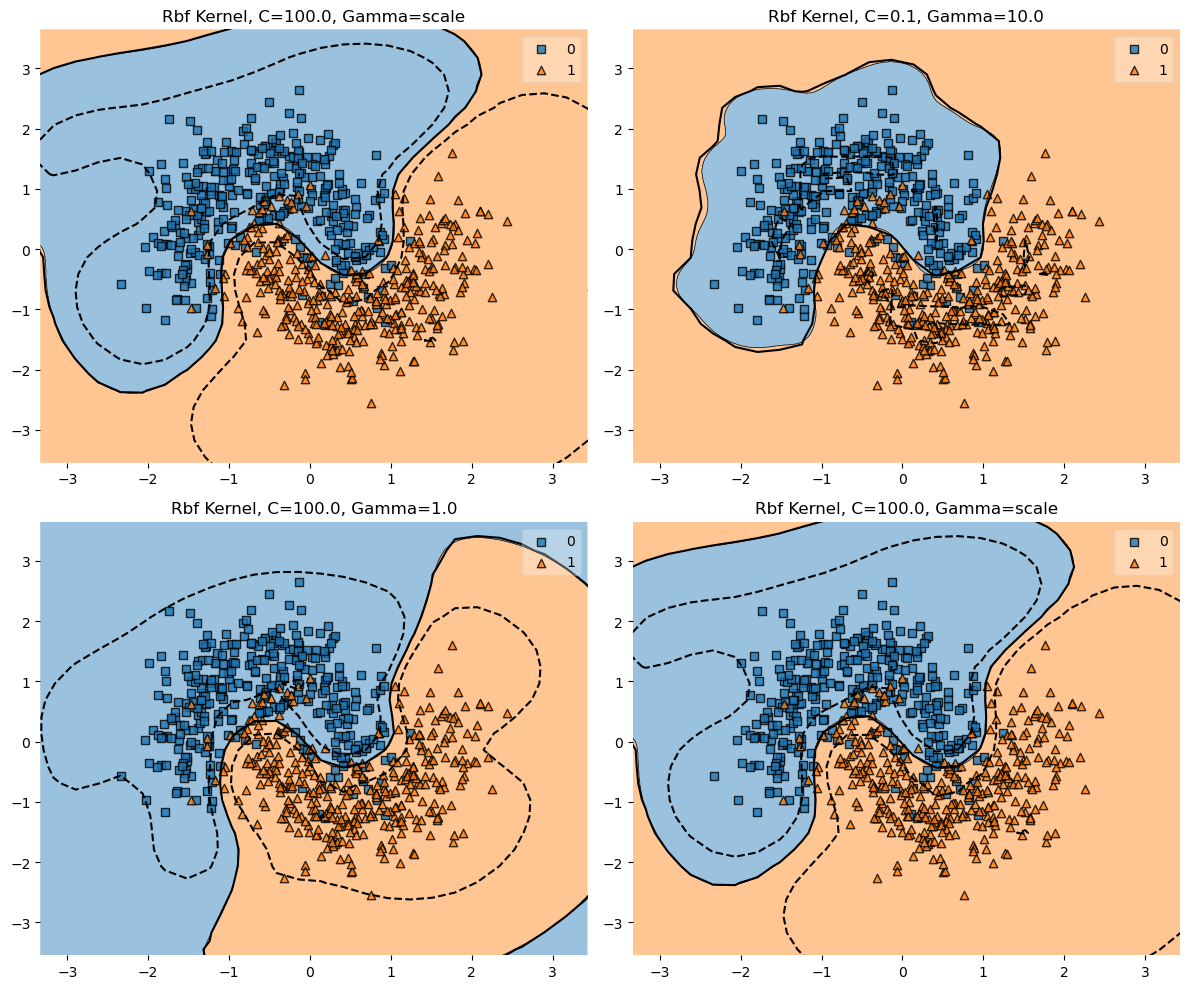

In [53]:
# Find the kernel/coefficient pair to describe the fit
gamma_classifiers = [find_gamma1.best_estimator_, 
                     find_gamma2.best_estimator_,
                     find_gamma3.best_estimator_,
                     find_C.best_estimator_]

# Plot each model's decision boundary analysis
fig, axes = plt.subplots(2,2, figsize=(12,10))
xx = np.linspace(-4, 4, 30)
yy = np.linspace(-4, 4, 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
for ax, clf in zip(axes.flatten(), gamma_classifiers):
    k, c, g = clf.get_params()['kernel'], clf.get_params()['C'], clf.get_params()['gamma']
    plot_decision_regions(X_train_scaled, y_train, clf=clf, ax=ax)
    Z = clf.decision_function(xy).reshape(XX.shape)
    ax.contour(XX, YY, Z, colors = 'k', levels = [-1, 0, 1], linestyles=["--", "-", "--"])
    ax.set_title(f'{k.capitalize()} Kernel, C={c}, Gamma={g}')
fig.tight_layout()

What I found most interesting in this visual was the swap of the majority class in the bottom two window panels by changing the $\gamma$ value and holding $C$ constant. Though the top right window panel $\gamma = 10$ | $C = 0.1$ provided us with the best accuracy score on the <b>test</b> data, we can observe its potential inefficiency were new data to be introduced, unless the data were to follow a similar mean input as the training data per class, keeping marginal violators in $C$ at a relative minimum (namely, the violations should hold the same rate as those introduced by the training data). However the larger $\gamma$ allows more precision weighting of the data points as they deviate further and further from the decision boundary, so we could deduce this model might make a better predictor. The next measure to help us decide would be to weigh our errors between the models.

> 6.  Inspect the evaluation measures such as MAE, MSE, or RMSE.

In [64]:
# Calculate Errors from model predictions
from sklearn.metrics import accuracy_score
for clf in gamma_classifiers[:-1]: # since 2 models are identical
    k, c, g = clf.get_params()['kernel'], clf.get_params()['C'], clf.get_params()['gamma']
    y_train_pred, y_test_pred = clf.predict(X_train_scaled), clf.predict(X_test_scaled)
    print(f'\nModel using {k.capitalize()} Kernel, C={c}, Gamma={g}')
    print(f'Gave an Accuracy Rate of :: {round(accuracy_score(y_train, y_train_pred), 4)}')
    print(f'& produced the following errors on the Training Data...')
    report_errors(clf, X_train_scaled, y_train)  # prediction accuracy
    print(f'...and on the Testing Data...')
    print(f'Gave an Accuracy Rate of :: {round(accuracy_score(y_test, y_test_pred), 4)}')
    report_errors(clf, X_test_scaled, y_test)  # true accuracy
    print(f'- - - - - - - - - - - - - - - - - - - - - - - - - - -')


Model using Rbf Kernel, C=100.0, Gamma=scale
Gave an Accuracy Rate of :: 0.9229
& produced the following errors on the Training Data...
Mean Absolute Error (MAE) :: 0.0771
Mean Squared Error (MSE) :: 0.0771
Root Mean Squared Error (RMSE) :: 0.2777

...and on the Testing Data...
Gave an Accuracy Rate of :: 0.9167
Mean Absolute Error (MAE) :: 0.0833
Mean Squared Error (MSE) :: 0.0833
Root Mean Squared Error (RMSE) :: 0.2887

- - - - - - - - - - - - - - - - - - - - - - - - - - -

Model using Rbf Kernel, C=0.1, Gamma=10.0
Gave an Accuracy Rate of :: 0.9243
& produced the following errors on the Training Data...
Mean Absolute Error (MAE) :: 0.0757
Mean Squared Error (MSE) :: 0.0757
Root Mean Squared Error (RMSE) :: 0.2752

...and on the Testing Data...
Gave an Accuracy Rate of :: 0.92
Mean Absolute Error (MAE) :: 0.08
Mean Squared Error (MSE) :: 0.08
Root Mean Squared Error (RMSE) :: 0.2828

- - - - - - - - - - - - - - - - - - - - - - - - - - -

Model using Rbf Kernel, C=100.0, Gamma=1.0
G

The `rbf` kernel using $C = 0.1$ and $\gamma = 10$ produces slightly better results on both the training and the testing data with better accuracy and reduced error.